In [61]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
import plotly as py 
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [62]:
# Read the excel file and create the dataframe
# Reading the data on which analysis needs to be done
retail = pd.read_csv('dataset/OnlineRetail.csv', encoding='ISO-8859-1', encoding_errors='ignore')
# Display first 10 rows
retail.head(10)



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


In [63]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [64]:
# DF Description
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Data Cleaning

In [65]:
# Calculating the Missing Values % Contribution in DF
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [66]:
# Droping the rows having missing values
retail = retail.dropna()
retail.shape

(406829, 8)

In [67]:
# Changing the datatype of Customer ID as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(str)
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.9+ MB


### Data Preparation

Customers will be analyzed based on 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of transactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [68]:
# New Attribute : Monetary
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head(5)

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [69]:
# New Attribute : Frequency
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head(5)


,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [70]:
# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
print(rfm.shape)
rfm.head(5)

(4372, 3)


,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [71]:
# New Attribute : Recency
# Convert to datetime to proper datatype
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')



In [72]:
# Compute the maximum date to know the last transaction date
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [73]:
# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [74]:
# Compute the last transaction date to get the recency of customers
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head(5)

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [75]:
# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head(5)

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [76]:
rfm.head(5)

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [77]:
# Merge the dataframe to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p , on='CustomerID', how='inner')

#

In [78]:
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### Rescaling the Attributes
It is extremely important to rescale the variables so that they have a comparable scale. There are two common ways of rescaling:
1. Min-max scaling
2. Standardization (mean-0, sigma-1) <br>
Here we execute Standard Scaling

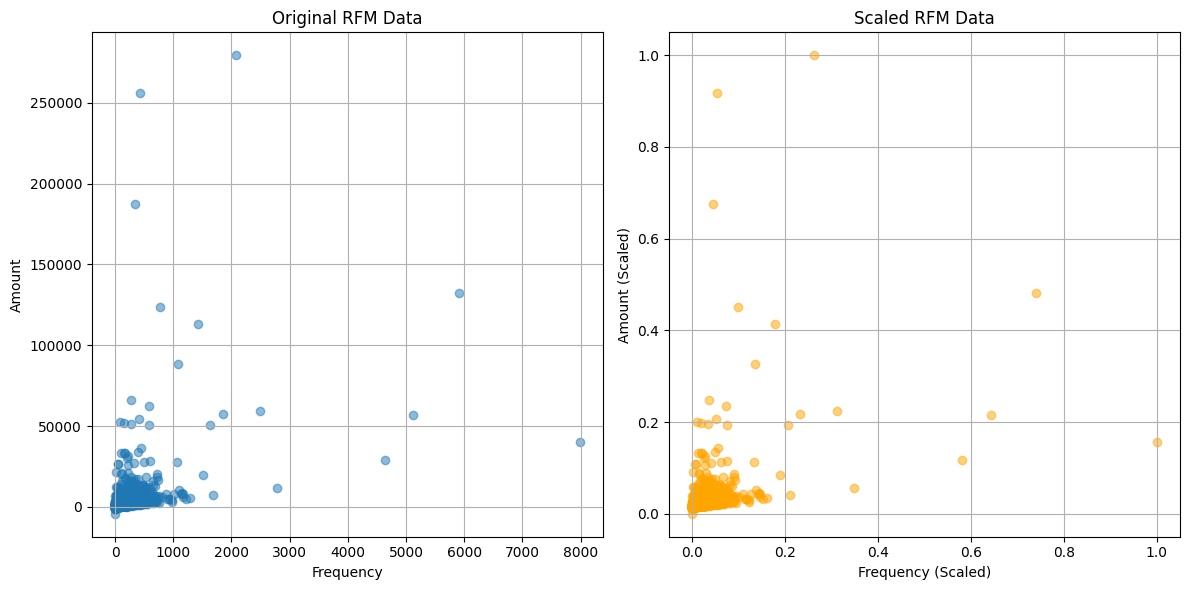

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Assuming rfm DataFrame is already defined
# Select relevant columns
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate Min-Max Scaler
min_max_scaler = MinMaxScaler()

# Fit and transform the RFM data
rfm_df_scaled = min_max_scaler.fit_transform(rfm_df)

# Convert the scaled data back to a DataFrame
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns=['Amount', 'Frequency', 'Recency'])

# Scatter plot before scaling
plt.figure(figsize=(12, 6))

# Scatter plot for original data
plt.subplot(1, 2, 1)
plt.scatter(rfm_df['Frequency'], rfm_df['Amount'], alpha=0.5)
plt.title('Original RFM Data')
plt.xlabel('Frequency')
plt.ylabel('Amount')
plt.grid(True)

# Scatter plot for scaled data
plt.subplot(1, 2, 2)
plt.scatter(rfm_df_scaled['Frequency'], rfm_df_scaled['Amount'], alpha=0.5, color='orange')
plt.title('Scaled RFM Data')
plt.xlabel('Frequency (Scaled)')
plt.ylabel('Amount (Scaled)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [80]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head(5)

,Amount,Frequency,Recency
0,0.015109,0.000125,0.871314
1,0.030297,0.022676,0.002681
2,0.021442,0.003758,0.198391
3,0.021303,0.009020,0.048257
4,0.016288,0.002005,0.828418


### Building the Model

#### K-Means Clustering
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.
The algorithm works as follows:
- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean's coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [81]:
# k-means with some arbitrary k
Kmeans = KMeans(n_clusters=4, max_iter=50)
Kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [82]:
Kmeans.labels_

array([3, 0, 2, ..., 0, 0, 0])

In [83]:
# Create a K-means function here
def K_Means(X, n):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model = KMeans(n)
    model.fit(X)
    cluster_labels = model.predict(X)
    cent = model.cluster_centers_
    return cluster_labels, cent

In [84]:
clust_labels, cent = K_Means(rfm_df, 3)
kmeans = pd.DataFrame(clust_labels)
rfm_df.insert((rfm_df.shape[1]), 'kmeans', kmeans)


In [85]:
rfm_df.head(5)

,Amount,Frequency,Recency,kmeans
0,0.00,2,325,0
1,4310.00,182,1,2
2,1797.24,31,74,2
3,1757.55,73,18,2
4,334.40,17,309,0


In [86]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Assuming rfm_df is already defined and scaled
num_clusters = 3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
rfm['kmeans'] = kmeans.fit_predict(rfm_df_scaled)

# Function to plot 3D Clusters
def Plot3dClustering(n, X, type_c):
    data = []
    colors = ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)']
    
    for i in range(n):
        x = X[X[type_c] == i]['Amount']
        y = X[X[type_c] == i]['Frequency']
        z = X[X[type_c] == i]['Recency']
        
        trace = go.Scatter3d(
            name=f'Cluster {i}',
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=3, color=colors[i], line=dict(width=0))
        )
        data.append(trace)

    layout = go.Layout(
        width=800,
        height=550,
        title='3D Clustering Plot',
        scene=dict(
            xaxis=dict(title='Amount', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            yaxis=dict(title='Frequency', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            zaxis=dict(title='Recency', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            aspectratio=dict(x=1, y=1, z=0.7),
            aspectmode='manual'
        ),
    )
    
    fig = go.Figure(data=data, layout=layout)
    pyo.iplot(fig, filename='3d-scatter-colorscale', validate=False)

# Function to plot Cluster Centroids
def PlotClusterCentroids(X, kmeans):
    centroids = kmeans.cluster_centers_
    centroids_df = pd.DataFrame(min_max_scaler.inverse_transform(centroids), columns=['Amount', 'Frequency', 'Recency'])

    centroid_trace = go.Scatter3d(
        name='Centroids',
        x=centroids_df['Amount'], 
        y=centroids_df['Frequency'], 
        z=centroids_df['Recency'],
        mode='markers',
        marker=dict(size=10, color='black', symbol='x', line=dict(width=1))
    )

    layout = go.Layout(
        width=800,
        height=550,
        title='Cluster Centroids Plot',
        scene=dict(
            xaxis=dict(title='Amount', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            yaxis=dict(title='Frequency', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            zaxis=dict(title='Recency', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            aspectratio=dict(x=1, y=1, z=0.7),
            aspectmode='manual'
        ),
    )

    fig = go.Figure(data=[centroid_trace], layout=layout)
    pyo.iplot(fig, filename='centroids-scatter', validate=False)

# Call the plotting functions
Plot3dClustering(n=num_clusters, X=rfm, type_c='kmeans')
PlotClusterCentroids(rfm, kmeans)


In [87]:
# Function to plot Cluster Centroids along with Clusters
def PlotClustersAndCentroids(X, kmeans):
    # Get unique clusters
    cluster_labels = np.unique(kmeans.labels_)

    data = []

    # Add cluster points to the plot
    for label in cluster_labels:
        cluster_data = X[kmeans.labels_ == label]
        trace = go.Scatter3d(
            name=f'Cluster {label}',
            x=cluster_data['Amount'],
            y=cluster_data['Frequency'],
            z=cluster_data['Recency'],
            mode='markers',
            marker=dict(size=3, line=dict(width=0)),
            opacity=0.5  # Set transparency for better visibility
        )
        data.append(trace)

    # Plot centroids
    centroids = kmeans.cluster_centers_
    centroids_df = pd.DataFrame(min_max_scaler.inverse_transform(centroids), columns=['Amount', 'Frequency', 'Recency'])
    
    centroid_trace = go.Scatter3d(
        name='Centroids',
        x=centroids_df['Amount'], 
        y=centroids_df['Frequency'], 
        z=centroids_df['Recency'],
        mode='markers',
        marker=dict(size=10, color='black', symbol='diamond', line=dict(width=1))  # Changed symbol to 'diamond'
    )
    data.append(centroid_trace)

    layout = go.Layout(
        width=800,
        height=550,
        title='Clusters and Centroids Plot',
        scene=dict(
            xaxis=dict(title='Amount', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            yaxis=dict(title='Frequency', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            zaxis=dict(title='Recency', gridcolor='rgb(255, 255, 255)', zerolinecolor='rgb(255, 255, 255)', showbackground=True, backgroundcolor='rgb(230, 230, 230)'),
            aspectratio=dict(x=1, y=1, z=0.7),
            aspectmode='manual'
        ),
    )

    fig = go.Figure(data=data, layout=layout)
    pyo.iplot(fig, filename='clusters-centroids-scatter', validate=False)

# Call the plotting functions
Plot3dClustering(n=num_clusters, X=rfm, type_c='kmeans')
PlotClustersAndCentroids(rfm, kmeans)


### Finding the Optimal Number of Clusters


#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine the optimal value of k.

Text(0.5, 1.0, 'Elbow Method')

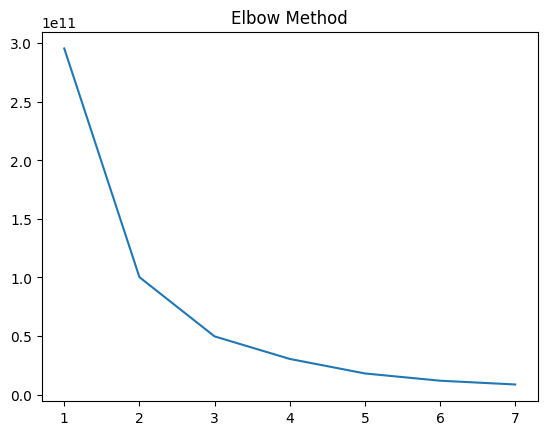

In [88]:
X = rfm_df
wcss = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=7, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,8), wcss)
plt.title('Elbow Method')